In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml



/Users/mezynski/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(42)

# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Images')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size

In [3]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [4]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_width, original_image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_center_relativ, y_center_relativ, width_relativ, height_relativ = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min = int((x_center_relativ - width_relativ / 2) * original_image_width)
                y_min = int((y_center_relativ - height_relativ / 2) * original_image_height)
                x_max = int((x_center_relativ + width_relativ / 2) * original_image_width)
                y_max = int((y_center_relativ + height_relativ / 2) * original_image_height)

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / original_image_width)
                y_min = int(y_min * input_shape[1] / original_image_height)
                x_max = int(x_max * input_shape[0] / original_image_width)
                y_max = int(y_max * input_shape[1] / original_image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[213, 165, 119],
          [213, 165, 119],
          [213, 165, 119],
          ...,
          [213, 165, 119],
          [213, 165, 119],
          [213, 165, 119]],
  
         [[213, 165, 119],
          [213, 165, 119],
          [213, 165, 119],
          ...,
          [213, 165, 119],
          [213, 165, 119],
          [213, 165, 119]],
  
         [[213, 165, 119],
          [213, 165, 119],
          [213, 165, 119],
          ...,
          [213, 165, 119],
          [213, 165, 119],
          [213, 165, 119]],
  
         ...,
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [186, 130,  74],
          [181, 126,  70],
          [191, 130,  70]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [178, 120,  63],
          [182, 125,  69],
          [194, 139,  84]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0

In [5]:
annotations[0]


[[256, 147, 466, 248 | 2],
 [253, 266, 454, 373 | 2],
 [254, 396, 455, 493 | 2],
 [263, 149, 360, 170 | 0],
 [265, 276, 357, 296 | 0],
 [254, 396, 384, 423 | 0],
 [263, 176, 448, 189 | 1],
 [260, 189, 448, 203 | 1],
 [260, 203, 452, 217 | 1],
 [261, 217, 452, 230 | 1],
 [261, 230, 451, 243 | 1],
 [260, 298, 449, 311 | 1],
 [260, 311, 449, 324 | 1],
 [260, 324, 450, 339 | 1],
 [257, 339, 450, 352 | 1],
 [257, 352, 450, 367 | 1],
 [260, 423, 451, 438 | 1],
 [258, 438, 451, 452 | 1],
 [258, 452, 451, 464 | 1],
 [260, 464, 451, 478 | 1],
 [260, 478, 449, 492 | 1]]

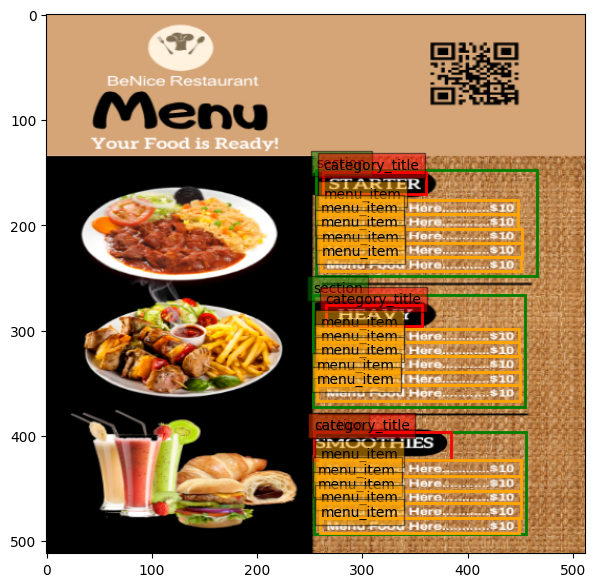

In [6]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color

color_map = {0: 'red', 1: 'orange', 2: 'green'}

def visualize_bounding_boxes(image, annotations):
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = annotation.xmin, annotation.ymin, annotation.xmax, annotation.ymax, annotation.class_id

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color_map[class_id], linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label_map[class_id], bbox=dict(facecolor=color_map[class_id], alpha=0.5))


plt.figure(figsize=(7, 7))

visualize_bounding_boxes(images[0], annotations[0])
plt.show()




In [7]:
# Draw 4 randim images with bounding boxes in a 2x2 grid
plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    random_index = np.random.randint(len(images))
    visualize_bounding_boxes(images[random_index], annotations[random_index])
plt.show()

KeyboardInterrupt: 

In [ ]:
def create_dir_or_clean(path):
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

def save_images_and_txt_files(images, annotations, image_path, label_path, file_base_name):
    for i, (train_image, train_annotation) in enumerate(zip(images, annotations)):
        image_name = f'{file_base_name}_{i}.jpg'
        label_name = f'{file_base_name}_{i}.txt'

        # Write the image to disk using cv2. Keep in mind that the images are in RGB and cv2 uses BGR by default
        cv2.imwrite(os.path.join(image_path, image_name), cv2.cvtColor(train_image, cv2.COLOR_RGB2BGR))

        with open(os.path.join(label_path, label_name), 'w') as f:
            for annotation in train_annotation:
                f.write(f"{annotation[0]} {annotation[1]} {annotation[2]} {annotation[3]} {annotation[4]}\n")


In [ ]:

# THis function has the following responsibilities:
# 1. Convert the annotations into the YOLO format
# 2. Split the data into train and validation sets
# 3. Save the data final_datasdet/images/train, final_datasdet/images/val and final_datasdet/labels/train, final_datasdet/labels/val
# 4. Save the label_map into final_datasdet/labels/darknet.labels
# 5. save the yolo configuration yaml file
def save_for_yolo_training(images, annotations):
    # Convert annotations into YOLO format
    yolo_annotations = []
    for sub_annotations in annotations:
        yolo_annotations.append([])
        for annotation in sub_annotations:
            x_center = (annotation.xmin + annotation.xmax) / 2
            y_center = (annotation.ymin + annotation.ymax) / 2
            width = annotation.xmax - annotation.xmin
            height = annotation.ymax - annotation.ymin

            # Normalize coordinates
            x_center /= input_shape[0]
            y_center /= input_shape[1]
            width /= input_shape[0]
            height /= input_shape[1]

            yolo_annotations[-1].append([annotation.class_id, x_center, y_center, width, height])

    # Split into train and validation sets
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, yolo_annotations, test_size=0.2, shuffle=True, random_state=42)

    # Create the directories
    image_train_path = 'final_dataset/images/train'
    image_val_path = 'final_dataset/images/val'
    label_train_path = 'final_dataset/labels/train'
    label_val_path = 'final_dataset/labels/val'
    create_dir_or_clean(image_train_path)
    create_dir_or_clean(image_val_path)
    create_dir_or_clean(label_train_path)
    create_dir_or_clean(label_val_path)

    # Save the images and labels
    save_images_and_txt_files(train_images, train_annotations, image_train_path, label_train_path, 'train')
    save_images_and_txt_files(val_images, val_annotations, image_val_path, label_val_path, 'val')

    # Copy the darknet.labels file to label train and val paths
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_train_path}')
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_val_path}')

    # Create and save the yolo configuration file
    yolo_config = {
        'path': os.path.abspath('final_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(label_map),
        'names': label_map,

    }
    yaml.dump(yolo_config, open('final_dataset/yolo_config.yaml', 'w'))


save_for_yolo_training(images, annotations)


In [ ]:
class grid_search_result:
    def __init__(self, name, results, params, output_path):
        self.name = name
        self.results = results
        self.params = params
        self.output_path = output_path
        

    def __repr__(self):
        stringRepr = f'name: {self.name}\nresults: {self.results}\nparams: {self.params}\noutput_path: {self.output_path}'
        return stringRepr

In [8]:
from ultralytics import YOLO
from sklearn.model_selection import ParameterGrid
import uuid
from IPython.display import clear_output
import pickle
import pandas as pd

def get_persisted_state_path(persist_filename):
    if persist_filename is not None:
        return f"./{persist_filename}.pkl"
    return None

def load_persisted_state(persist_path):
    if os.path.exists(persist_path):
        with open(persist_path, 'rb') as f:
            return pickle.load(f)
    return None

def train_yolo_model(name, learning_rate, batch_size, num_epochs, netw_arch, confidence):
    model = YOLO(f"{netw_arch}.yaml").load(f"{netw_arch}.pt") # from local file

    results = model.train(data = "./final_dataset/yolo_config.yaml",lrf = learning_rate, epochs = num_epochs, batch = batch_size, name = name, conf = confidence)
    return model, results

def run_grid_search(learning_rates=[], batch_sizes=[], epochs=[], netw_archs=[], confidences=[], nms_thresholds=[], persist_state_filename=None):
    persist_path = None
    persisted_state = None
    if persist_state_filename is not None:
        persist_path = get_persisted_state_path(persist_state_filename)
        persisted_state = load_persisted_state(persist_path)

    if persisted_state is not None:
        print(f"Restoring persisted state from {persist_path}")

    pm_grid_space = persisted_state['pm_grid_space'] if persisted_state is not None else {'learning_rate': learning_rates,
                    'batch_size': batch_sizes,
                    'epochs': epochs,
                    'network_architecture': netw_archs,
                    'confidence': confidences}

    pm_grid = ParameterGrid(pm_grid_space)

    resultsList = persisted_state['resultsDict'] if persisted_state is not None else []

    index = persisted_state['index'] if persisted_state is not None else 0

    for index in range(index, len(pm_grid)):
        print(f"Training model {index+1}/{len(pm_grid)}........")

        name = "train-" + str(uuid.uuid4())
        params = pm_grid[index]
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        num_epochs = params['epochs']
        netw_arch = params['network_architecture']
        confidence = params['confidence']
        #nms_thresh = params['NMS_threshold']

        print(f"Params:\nlearning_rate: {learning_rate}\nbatch_size: {batch_size}\nnum_epochs: {num_epochs}\nnetwork_architecture: {netw_arch}\nconfidence: {confidence}")

        model, results = train_yolo_model(name, learning_rate, batch_size, num_epochs, netw_arch, confidence)

        # Load csv from save_dir/results.csv into a dataframe
        csv_path = os.path.join(results.save_dir, 'results.csv')
        results_df = pd.read_csv(csv_path)
        results_df.rename(columns=lambda x: x.strip(), inplace=True)

        # Get the best epoch in terms of validation loss and put that row in a dictionary
        best_epoch = results_df.loc[results_df['val/box_loss'].idxmin()].to_dict()

        resultsList.append(grid_search_result(name, best_epoch, params, results.save_dir))

        index += 1

        if persist_path is not None:
            # Save pm_grid and index and resultsDict to file
            with open(persist_path, 'wb') as f:
                pickle.dump({'pm_grid_space': pm_grid_space, 'index': index, 'resultsDict': resultsList}, f)

        clear_output(wait=True)

    return resultsList


In [ ]:
# hyperparameters to search through
learning_rates = [0.1]
batch_sizes = [16,32]
epochs = [2,10]
netw_archs = ["yolov8m","yolov8x"]
confidences = [0.5,0.75]

resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, persist_state_filename='grid_search_state_1')
# resultsList


In [ ]:
# Load the persisted state
persisted_state = load_persisted_state(get_persisted_state_path('grid_search_state_1'))
print(persisted_state['resultsDict'])

[name: train-a7beba73-d565-4e4c-a825-ed5e52d59864
results: {'epoch': 2.0, 'train/box_loss': 2.9501, 'train/cls_loss': 3.317, 'train/dfl_loss': 2.3335, 'metrics/precision(B)': 0.03106, 'metrics/recall(B)': 0.22222, 'metrics/mAP50(B)': 0.02146, 'metrics/mAP50-95(B)': 0.00597, 'val/box_loss': 2.6333, 'val/cls_loss': 12.187, 'val/dfl_loss': 2.0131, 'lr/pg0': 7.0736e-05, 'lr/pg1': 7.0736e-05, 'lr/pg2': 7.0736e-05}
params: {'network_architecture': 'yolov8m', 'learning_rate': 0.1, 'epochs': 2, 'confidence': 0.5, 'batch_size': 16}
output_path: /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-a7beba73-d565-4e4c-a825-ed5e52d59864]


In [ ]:
def find_best_model(resultsDict, metric="metrics/mAP50(B)"):
    """
    Finds the best model in the resultsDict based on the metric
    :param resultsDict: list of grid_search_result objects
    :param metric: metric to compare the models with. Available metrics are: metrics/precision(B), metrics/recall(B), metrics/mAP50(B), metrics/mAP50-95(B)
    """
    best_model_results = None
    best_metric = -1
    for result in resultsDict:
        if result.results[metric] > best_metric:
            best_model_results = result
            best_metric = result.results[metric]

    return best_model_results




In [ ]:
def print_best_models(resultsDict):
    best_model_results = find_best_model(resultsDict)
    print("mAP50\n", best_model_results)

    best_model_results = find_best_model(resultsDict, metric="metrics/mAP50-95(B)")
    print("\nmAP50-95\n", best_model_results)

    best_model_results = find_best_model(resultsDict, metric="metrics/precision(B)")
    print("\nprecision\n", best_model_results)

    best_model_results = find_best_model(resultsDict, metric="metrics/recall(B)")
    print("\nrecall\n", best_model_results)


In [ ]:
print_best_models(persisted_state['resultsDict'])

mAP50
 name: train-a7beba73-d565-4e4c-a825-ed5e52d59864
results: {'epoch': 2.0, 'train/box_loss': 2.9501, 'train/cls_loss': 3.317, 'train/dfl_loss': 2.3335, 'metrics/precision(B)': 0.03106, 'metrics/recall(B)': 0.22222, 'metrics/mAP50(B)': 0.02146, 'metrics/mAP50-95(B)': 0.00597, 'val/box_loss': 2.6333, 'val/cls_loss': 12.187, 'val/dfl_loss': 2.0131, 'lr/pg0': 7.0736e-05, 'lr/pg1': 7.0736e-05, 'lr/pg2': 7.0736e-05}
params: {'network_architecture': 'yolov8m', 'learning_rate': 0.1, 'epochs': 2, 'confidence': 0.5, 'batch_size': 16}
output_path: /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-a7beba73-d565-4e4c-a825-ed5e52d59864

mAP50-95
 name: train-a7beba73-d565-4e4c-a825-ed5e52d59864
results: {'epoch': 2.0, 'train/box_loss': 2.9501, 'train/cls_loss': 3.317, 'train/dfl_loss': 2.3335, 'metrics/precision(B)': 0.03106, 'metrics/recall(B)': 0.22222, 'metrics/mAP50(B)': 0.02146, 'metrics/mAP50-95(B)': 0.00597, 'val/box_loss': 2.6333, 'val/cls_loss': 12.187, 'val/dfl

In [ ]:
# hyperparameters to search through
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16]
epochs = [10, 16]
netw_archs = ["yolov8x"]
confidences = [0.5,0.7,0.9]

# resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, persist_state_filename='grid_search_state_2')
# resultsList


In [ ]:
persisted_state_2 = load_persisted_state(get_persisted_state_path('grid_search_state_2'))
print_best_models(persisted_state_2['resultsDict'])


mAP50
 name: train-157fccdf-e2ca-4833-981c-5230bfaf9f6c
results: {'metrics/precision(B)': 0.6245094594781945, 'metrics/recall(B)': 0.7231556735416241, 'metrics/mAP50(B)': 0.6914025988269916, 'metrics/mAP50-95(B)': 0.42429682015011594, 'fitness': 0.45100739801780354}
params: {'network_architecture': 'yolov8x', 'learning_rate': 0.001, 'epochs': 16, 'confidence': 0.5, 'batch_size': 16}
output_path: runs/detect/train-157fccdf-e2ca-4833-981c-5230bfaf9f6c

mAP50-95
 name: train-b5af3341-55c7-4a59-b6f4-a8ef7e589843
results: {'metrics/precision(B)': 0.6223424147155784, 'metrics/recall(B)': 0.7241596896058812, 'metrics/mAP50(B)': 0.6874067476425977, 'metrics/mAP50-95(B)': 0.4309731943934668, 'fitness': 0.4566165497183799}
params: {'network_architecture': 'yolov8x', 'learning_rate': 0.001, 'epochs': 16, 'confidence': 0.7, 'batch_size': 16}
output_path: runs/detect/train-b5af3341-55c7-4a59-b6f4-a8ef7e589843

precision
 name: train-157fccdf-e2ca-4833-981c-5230bfaf9f6c
results: {'metrics/precision(

In [ ]:
# hyperparameters to search through
# learning_rates = [0.0005, 0.001, 0.005]
# batch_sizes = [16]
# epochs = [16]
# netw_archs = ["yolov8x"]
# confidences = [0.5,0,6,0.7,0.8]

# resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, persist_state_filename='grid_search_state_3')


In [ ]:
# persisted_state_3 = load_persisted_state(get_persisted_state_path('grid_search_state_3'))
# print_best_models(persisted_state_3['resultsDict'])

In [ ]:
# Train the best model on the entire dataset
best_model_results = find_best_model(persisted_state_2['resultsDict'], metric="metrics/mAP50(B)")
best_params = best_model_results.params

model, results = train_yolo_model("best_model", best_params['learning_rate'], best_params['batch_size'], best_params['epochs'], best_params['network_architecture'], best_params['confidence'])

In [ ]:
# Load the best model from the disk
model = YOLO(f"{best_params['network_architecture']}.yaml").load(os.path.join(results.save_dir, 'best.pt'))


In [55]:
from ultralytics.utils.plotting import (
    Annotator,
)


def create_img_with_bounding_boxes(image, filter_classes=[]):
    results = model.predict(image)

    annotator = Annotator(image)
    boxes = results[0].boxes
    for box in boxes:
        b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
        c = box.cls
        classname = model.names[int(c)]
        if len(filter_classes) > 0 and classname not in filter_classes:
            continue

        annotator.box_label(b, classname, color=(int(c * 70) % 255, 128, 128))

    img = annotator.result()
    return img



0: 640x640 27 2s, 40 17s, 1 59, 631.1ms
Speed: 4.8ms preprocess, 631.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 23 2s, 98 17s, 1 24, 6 35s, 10 69s, 518.2ms
Speed: 1.8ms preprocess, 518.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 2s, 11 17s, 3 24s, 1 59, 447.2ms
Speed: 2.0ms preprocess, 447.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 447.8ms
Speed: 2.0ms preprocess, 447.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 2s, 1 14, 63 17s, 1 24, 1 35, 47 69s, 461.6ms
Speed: 1.8ms preprocess, 461.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 464.5ms
Speed: 2.1ms preprocess, 464.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 2s, 4 17s, 471.7ms
Speed: 3.0ms preprocess, 471.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0

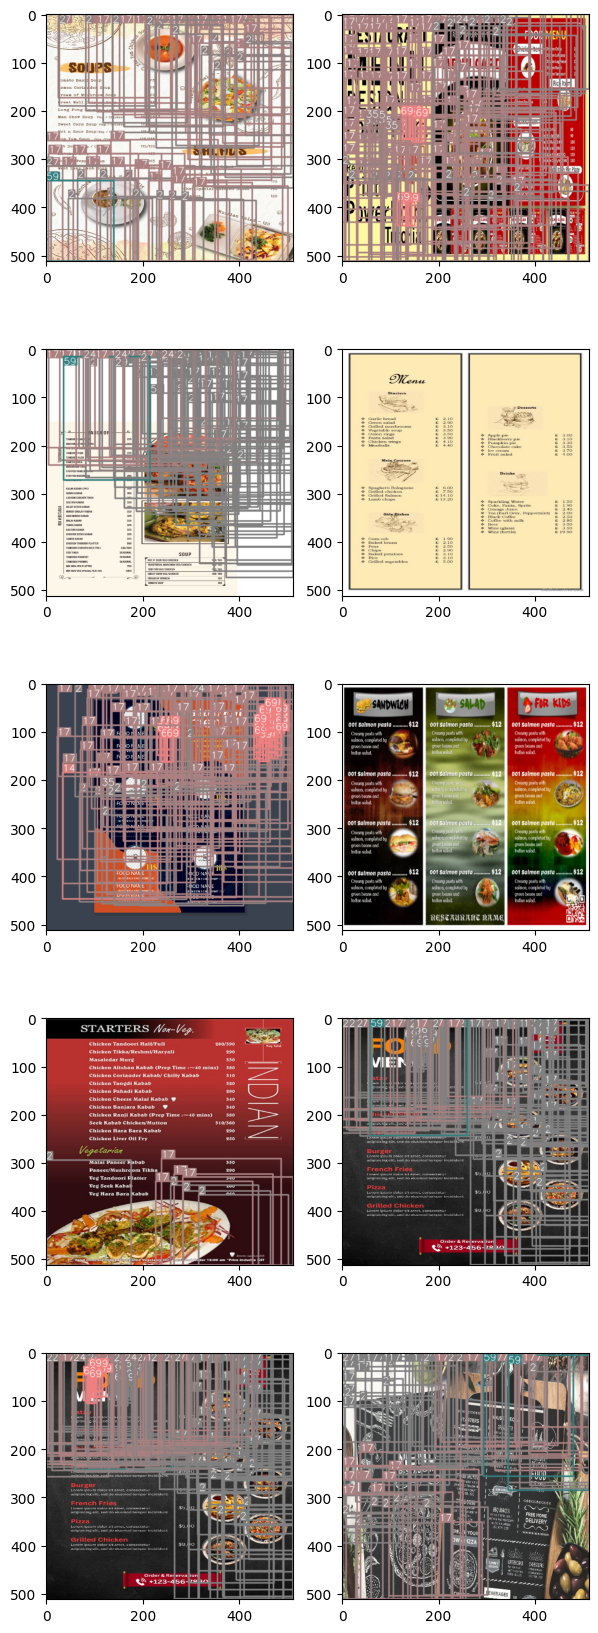

In [56]:
plt.figure(figsize=(7, 21))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=10)
for idx, random_index in enumerate(random_indices):
    img = images[random_index]
    img_with_bb = create_img_with_bounding_boxes(img)

    # Plot the image with bounding boxes
    plt.subplot(5, 2, idx + 1)
    plt.imshow(img_with_bb)

plt.show()


0: 640x640 8 2s, 10 17s, 536.9ms
Speed: 6.2ms preprocess, 536.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 2s, 35 17s, 2 24s, 2 59s, 17 69s, 433.9ms
Speed: 1.7ms preprocess, 433.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 2s, 19 17s, 1 24, 409.0ms
Speed: 4.4ms preprocess, 409.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 2s, 10 17s, 412.9ms
Speed: 2.1ms preprocess, 412.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 2s, 7 17s, 418.1ms
Speed: 1.8ms preprocess, 418.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 2s, 12 17s, 1 59, 7 69s, 405.5ms
Speed: 2.1ms preprocess, 405.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 2s, 83 17s, 2 59s, 42 69s, 417.9ms
Speed: 2.3ms preprocess, 417.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 2s, 11

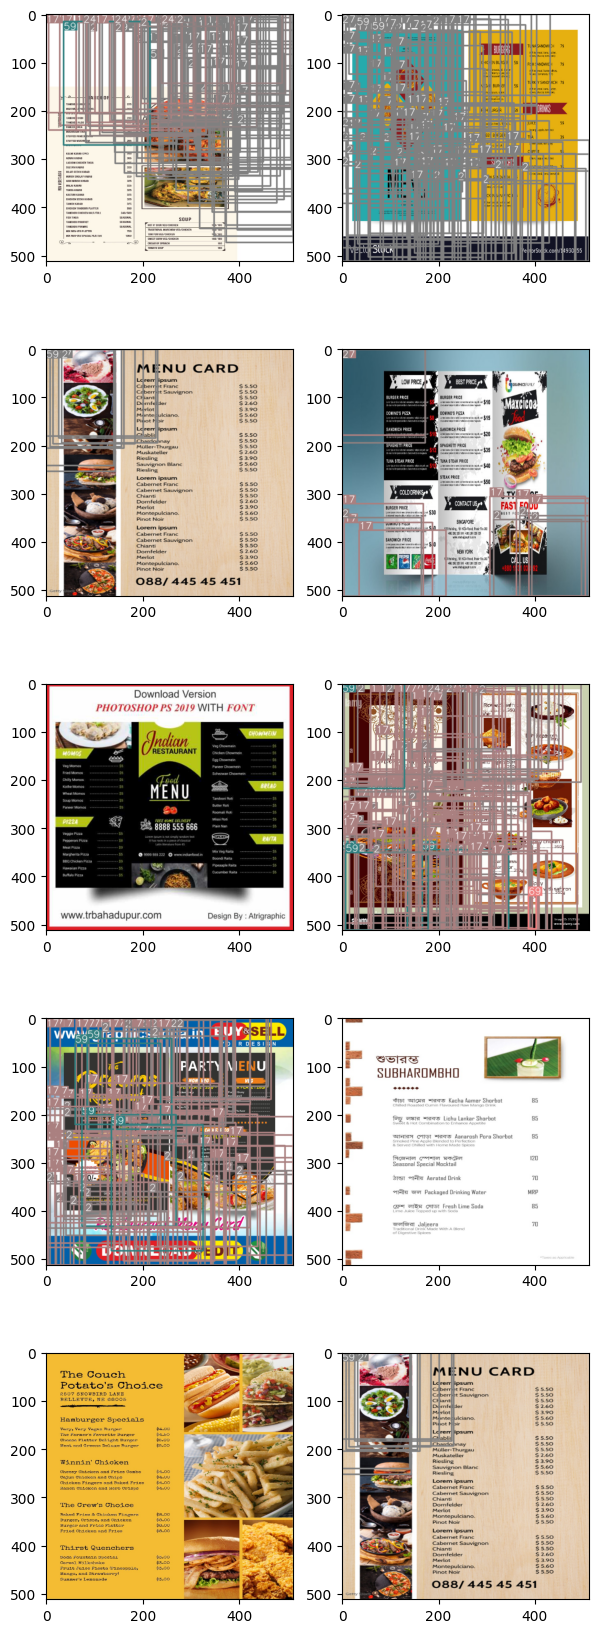


0: 640x640 12 2s, 29 17s, 2 59s, 426.1ms
Speed: 2.2ms preprocess, 426.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 419.0ms
Speed: 2.1ms preprocess, 419.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 2s, 11 17s, 417.8ms
Speed: 2.2ms preprocess, 417.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 2s, 10 17s, 410.2ms
Speed: 1.8ms preprocess, 410.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 26 2s, 50 17s, 9 35s, 2 51s, 1 59, 11 69s, 4 73s, 408.2ms
Speed: 2.9ms preprocess, 408.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 2s, 34 17s, 2 24s, 2 59s, 411.8ms
Speed: 3.9ms preprocess, 411.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 397.2ms
Speed: 2.0ms preprocess, 397.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640

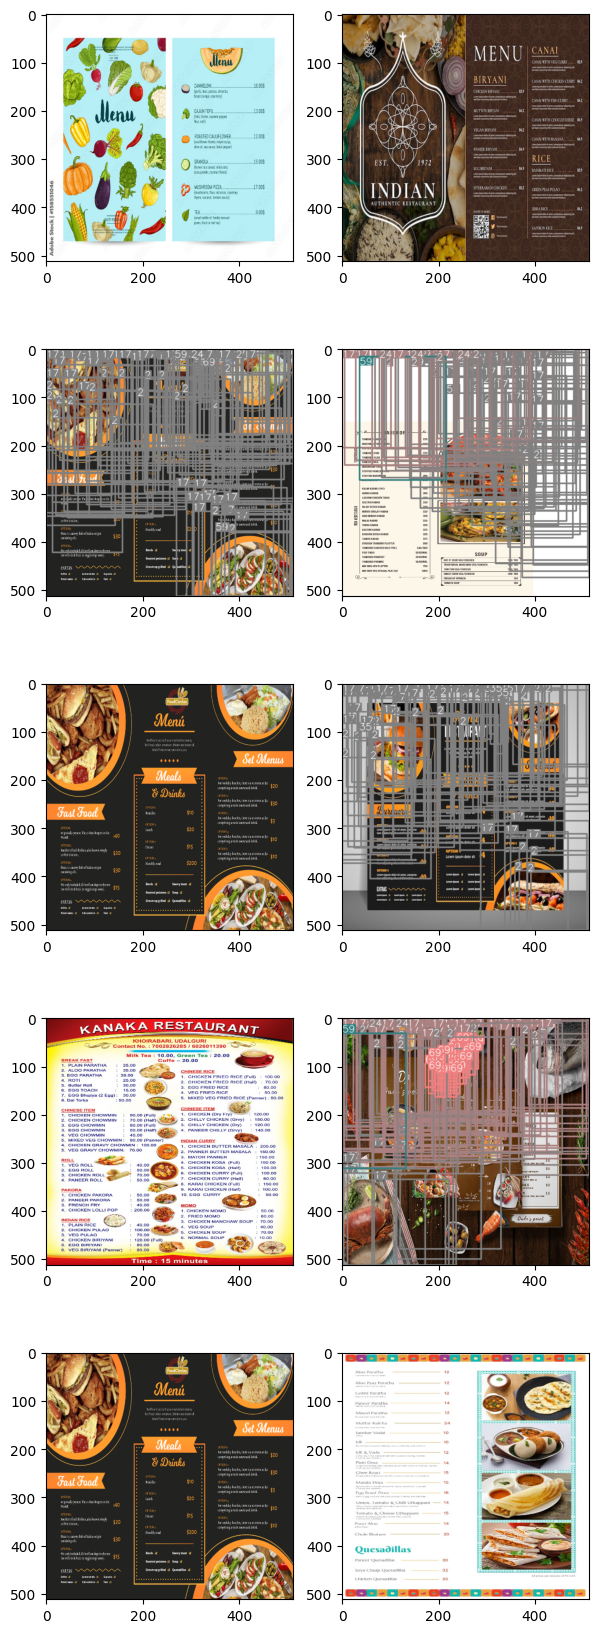


0: 640x640 22 2s, 62 17s, 73 69s, 463.8ms
Speed: 3.0ms preprocess, 463.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 2s, 2 17s, 405.6ms
Speed: 2.2ms preprocess, 405.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 25 2s, 27 17s, 545.3ms
Speed: 1.8ms preprocess, 545.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 18 2s, 48 17s, 1 59, 454.2ms
Speed: 2.3ms preprocess, 454.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 2s, 15 17s, 3 59s, 436.6ms
Speed: 1.7ms preprocess, 436.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 2s, 39 17s, 3 24s, 432.2ms
Speed: 3.1ms preprocess, 432.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 18 2s, 15 17s, 407.3ms
Speed: 1.9ms preprocess, 407.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 21 2s, 126 17s, 11 35s, 14 69s, 

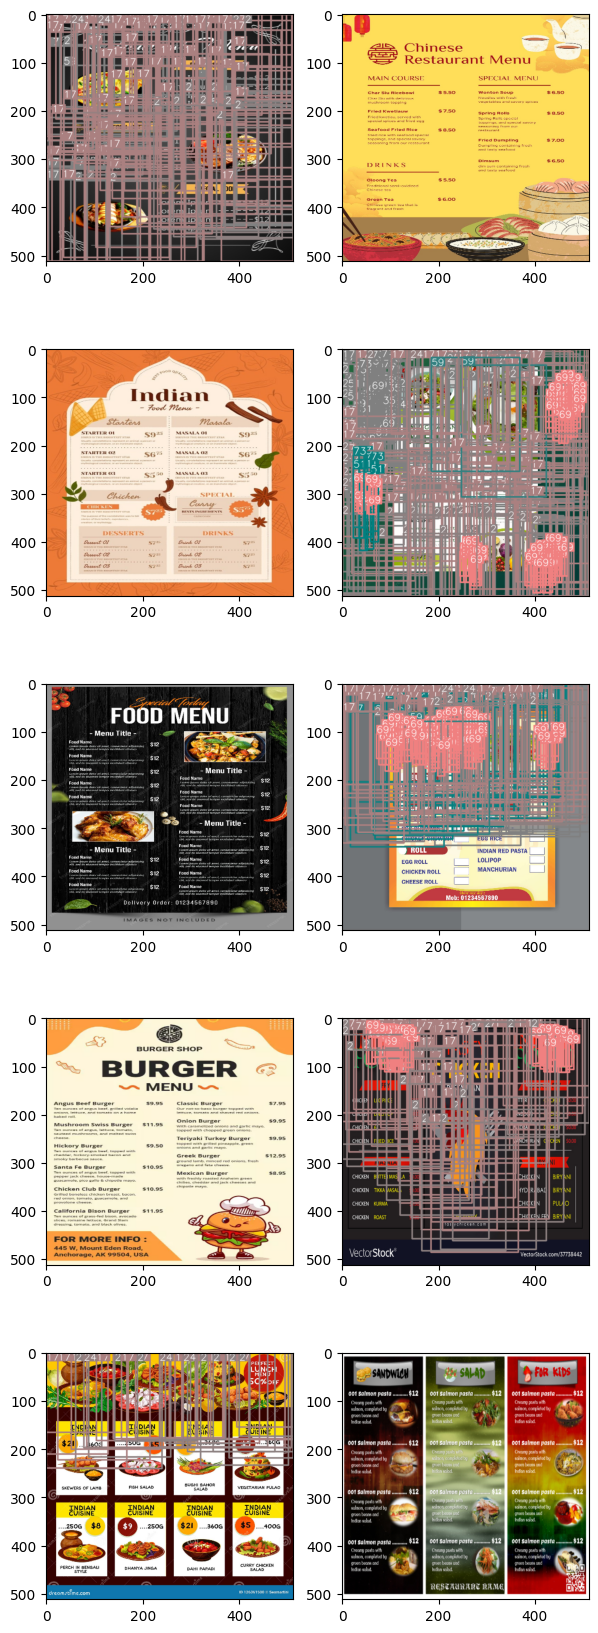

In [57]:
plt.figure(figsize=(7, 21))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=10)
for idx, random_index in enumerate(random_indices):
    img = images[random_index]
    img_with_bb = create_img_with_bounding_boxes(img, ["category_title"])

    # Plot the image with bounding boxes
    plt.subplot(5, 2, idx + 1)
    plt.imshow(img_with_bb)

plt.show()

plt.figure(figsize=(7, 21))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=10)
for idx, random_index in enumerate(random_indices):
    img = images[random_index]
    img_with_bb = create_img_with_bounding_boxes(img, ["menu_item"])

    # Plot the image with bounding boxes
    plt.subplot(5, 2, idx + 1)
    plt.imshow(img_with_bb)

plt.show()

plt.figure(figsize=(7, 21))
# Take some random images from the dataset and run the model on them
random_indices = np.random.randint(len(images), size=10)
for idx, random_index in enumerate(random_indices):
    img = images[random_index]
    img_with_bb = create_img_with_bounding_boxes(img, ["section"])

    # Plot the image with bounding boxes
    plt.subplot(5, 2, idx + 1)
    plt.imshow(img_with_bb)

plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import shutil

# # Define the source directory and the destination directory
# source_dir = '/content/runs'
# destination_dir = '/content/drive/MyDrive/Fontys/SEMESTER_7/DASC2/Model'

# # Copy the directory
# shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)